In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install transformers numpy nltk ipywidgets tqdm pandas

In [271]:
import pandas as pd
import torch
from transformers import AutoModelForCausalLM

torch.set_printoptions(sci_mode=False, precision=4)

In [272]:
df = pd.read_csv('data/vocab.csv', dtype={'token': 'string', 'id': 'Int64'})

df['tokenCleaned'] = df['token']
# df['tokenCleaned'] = df['tokenCleaned'].str.replace("Ġ", "")
df['tokenCleaned'] = df['tokenCleaned'].apply(lambda x: x[1:] if isinstance(x, str) and x[0] == "Ġ" else x) # only replace if space is first letter
# df['tokenCleaned'] = df['tokenCleaned'].str.lower()
# df['tokenCleaned'] = df['tokenCleaned'].apply(lambda x: x[0].lower() + x[1:] if isinstance(x, str) and len(x) > 1 else x)
df['isDuplicated'] = df.duplicated(subset='tokenCleaned', keep='first')

print(df)

duplicate_count = len(df[df['isDuplicated']])
print("Duplicate count:", duplicate_count, round(duplicate_count / len(df), 4))

               token     id   tokenCleaned  isDuplicated
0                  !      0              !         False
1                  "      1              "         False
2                  #      2              #         False
3                  $      3              $         False
4                  %      4              %         False
...              ...    ...            ...           ...
50252       Ġregress  50252        regress         False
50253      ĠCollider  50253       Collider         False
50254    Ġinformants  50254     informants         False
50255         Ġgazed  50255          gazed         False
50256  <|endoftext|>  50256  <|endoftext|>         False

[50257 rows x 4 columns]
Duplicate count: 8535 0.1698


In [273]:
model = AutoModelForCausalLM.from_pretrained("gpt2")

vocab_map = dict(zip(df['token'], df['id']))

print(vocab_map["cat"], vocab_map["Ġcat"])

9246 3797


In [274]:
input_embedding = model.transformer.wte.weight.detach()

def emb(token):
    if not token in vocab_map:
        raise Exception(f"Token {token} doesn't exist")
    return input_embedding[vocab_map[token]]

def embdiff(token, lowercase=False, space=True):
    if space: return emb(f"Ġ{token}") - emb(token)
    if lowercase: return emb(token[0].lower() + token[1:]) - emb(token[0].upper() + token[1:])
    return None

cat = emb("cat")
cat_space = emb("Ġcat")
cat_diff = cat_space - cat

print(embdiff("cat"))

tensor([     0.0263,      0.1300,     -0.0784,     -0.3583,     -0.0102,
             0.1613,     -0.0637,      0.0878,     -0.0556,     -0.1776,
            -0.0493,      0.0821,     -0.1670,     -0.1072,      0.0421,
             0.1941,     -0.1681,     -0.0218,     -0.2110,      0.1078,
             0.1444,      0.1671,     -0.1413,     -0.0094,      0.1023,
             0.1005,      0.0819,     -0.1063,      0.1130,      0.0483,
            -0.1853,      0.0569,      0.0420,      0.0368,     -0.0517,
            -0.0094,      0.0039,      0.0801,     -0.0845,     -0.0263,
             0.2704,     -0.2114,     -0.0502,      0.0965,     -0.0719,
            -0.2363,     -0.0254,      0.0353,     -0.1405,      0.0463,
            -0.0827,     -0.1030,     -0.1210,     -0.0351,      0.0000,
            -0.0396,     -0.2279,     -0.0725,      0.1611,      0.1175,
             0.2111,      0.0249,      0.1197,      0.0655,     -0.1543,
             0.0812,     -0.1284,     -0.1046,     

In [275]:
def error(x, y):
    return torch.mean(torch.abs((x - y))).item()

common_objects = ["car", "house", "book", "table", "phone", "computer", "pen", "window", "hat", "key", "ball", "box"]

diffs = [embdiff(word) for word in common_objects]
diffs = torch.stack(diffs)
print(diffs.shape)
average_diff = torch.mean(diffs, dim=0)
print(average_diff.shape)


cat_diff = embdiff("cat")
dog_diff = embdiff("dog")

print(error(cat_diff, dog_diff))
print(error(cat_diff, average_diff))
print(error(dog_diff, average_diff))

torch.Size([12, 768])
torch.Size([768])
0.11110951751470566
0.08943405747413635
0.08299724012613297


In [276]:
df_duplicated = df[df['isDuplicated'] & (df['tokenCleaned'].str.len() >= 4)]

token_diffs = []
for token in df_duplicated['tokenCleaned']:
    token_diffs.append(embdiff(token))

token_diffs = torch.stack(token_diffs)

token_space = torch.mean(token_diffs, dim=0)
print(token_space.shape)

# token_diffs = token_diffs - token_space

print(len(token_diffs))

torch.Size([768])
5294


tensor([[-0.0629,  0.0832, -0.1803,  ...,  0.2064, -0.0244,  0.0458],
        [ 0.1104, -0.1578,  0.0243,  ..., -0.1699, -0.1065, -0.1200],
        [ 0.2089, -0.0621,  0.0050,  ..., -0.0683,  0.1385, -0.2027],
        ...,
        [-0.0624,  0.1199, -0.0285,  ...,  0.0965, -0.2751,  0.0764],
        [ 0.0057,  0.1176, -0.2855,  ...,  0.1185,  0.1109,  0.0926],
        [-0.1166, -0.0500,  0.0692,  ...,  0.2538,  0.0899, -0.1560]])


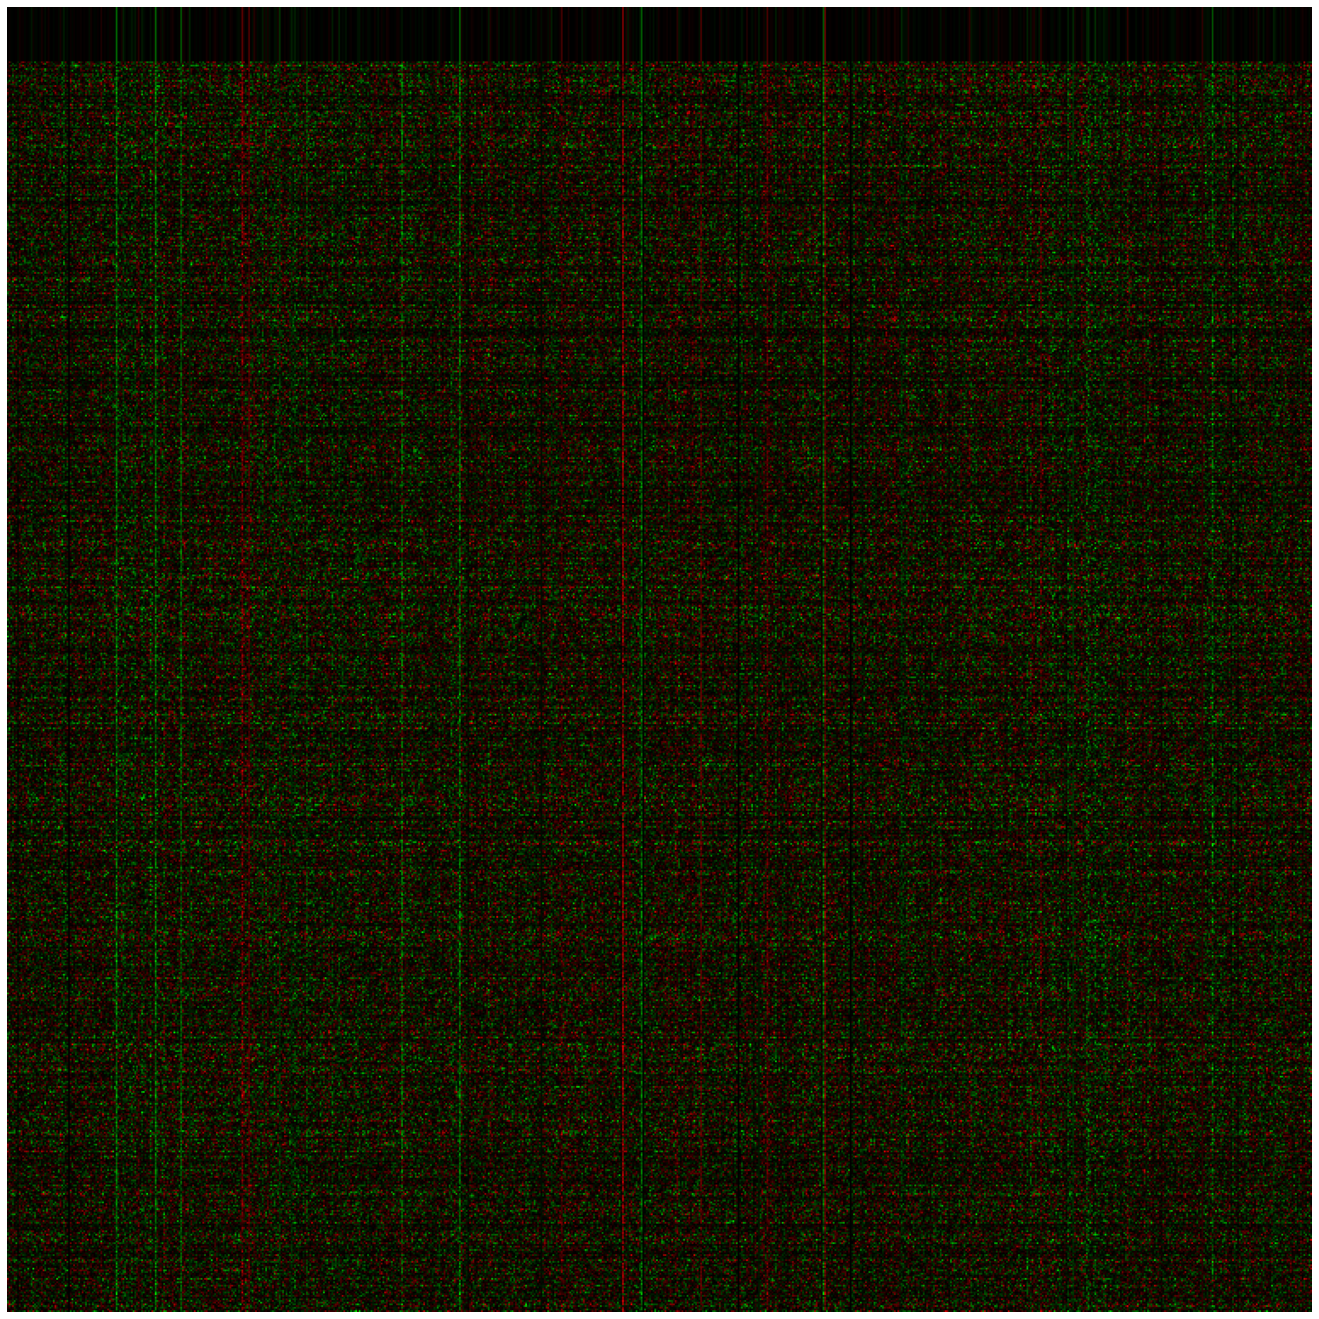

In [277]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(token_diffs[0:16])

token_diffs_sel = token_diffs[0:768].numpy()
token_diffs_sel[0:32] = token_space

image = np.zeros((token_diffs_sel.shape[0], token_diffs_sel.shape[1], 3), dtype=np.uint8)
image[:, :, 0] = 2 * (np.maximum(token_diffs_sel, 0) * 255).astype(np.uint8)
image[:, :, 1] = 2 * (np.abs(np.minimum(token_diffs_sel, 0)) * 255).astype(np.uint8)

img = Image.fromarray(image)

img.save('data/diff.png', 'PNG')

plt.figure(figsize=(24, 24))
plt.imshow(image)
plt.axis('off')
plt.show()
